## Deep Learning Regularization
We will explore different regularization methods and observe changes to loss and accuracy.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


## Import the Fashion MNIST dataset and Preprocess
Store class names under `class_names` and normalize the data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [3]:
x_train_scaled = x_train / 255.0
x_test_scaled = x_test / 255.0

## Base Accuracy
Using the Keras Sequential model, we will train a model to establish a baseline at 10 epochs

In [4]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [5]:
history_base = model.fit(x_train_scaled, y_train, epochs=10,
                         validation_data=(x_test_scaled, y_test),verbose=0)

In [6]:
test_loss_base, test_acc_base = model.evaluate(x_test_scaled, y_test, verbose=0)
print('\nTest Loss:', test_loss_base)
print('\nTest Accuracy:', test_acc_base)


Test Loss: 0.3328584358215332

Test Accuracy: 0.8846


## Parameter Norm Penalties
Instead of a simple rectified linear model, we will use a regularized model, in this case we will adjust the L2 norm penalty on weights

In [7]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='elu', 
                       kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [8]:
history_pnp = model.fit(x_train_scaled, y_train, epochs=10,
                        validation_data=(x_test_scaled, y_test),verbose=0)

In [9]:
test_loss_pnp, test_acc_pnp = model.evaluate(x_test_scaled, y_test, verbose=0)
test_acc_diff = test_acc_pnp - test_acc_base
test_loss_diff = test_loss_pnp - test_loss_base
print('\nTest Loss:', test_loss_pnp)
print('\nTest Accuracy:', test_acc_pnp)
print('\nTest Loss Difference:', test_loss_diff)
print('\nTest Accuracy Difference:', test_acc_diff)


Test Loss: 0.6291851170063019

Test Accuracy: 0.8102

Test Loss Difference: 0.2963266811847687

Test Accuracy Difference: -0.07440001


Test Accuracy test accuracy went down and loss increased under `l2(0.01)`

## Dropout
Now we will instead try dropout layers which remove a features influence randomly during training to improve robustness to feature loss

In [10]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [11]:
history_drop = model.fit(x_train_scaled, y_train, epochs=10,
                         validation_data=(x_test_scaled, y_test),verbose=0)

In [12]:
test_loss_drop, test_acc_drop = model.evaluate(x_test_scaled, y_test, verbose=0)
test_acc_diff = test_acc_drop - test_acc_base
test_loss_diff = test_loss_drop - test_loss_base
print('\nTest Loss:', test_loss_drop)
print('\nTest Accuracy:', test_acc_drop)
print('\nTest Loss Difference:', test_loss_diff)
print('\nTest Accuracy Difference:', test_acc_diff)


Test Loss: 0.33070659297704696

Test Accuracy: 0.8802

Test Loss Difference: -0.002151842844486218

Test Accuracy Difference: -0.0043999553


Test Accuracy and Test loss were slightly lower under `Dropout(0.05)`

## Early Stopping
Increasing epochs can increase accuracy initially but there is a chance of eventually a decraese in test set accuracy. 
- We will use `callbacks` set up early stopping. 
- With `patience=10` the training will halt if accuracy isn't improved within 10 epochs.
- With `restore_best_weights=True` the model from the last best epoch will be returned

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [15]:
cb = [EarlyStopping(monitor='val_accuracy',patience=5, restore_best_weights=True)]

In [16]:
history_es = model.fit(x_train_scaled, y_train, epochs=1000,
                         validation_data=(x_test_scaled, y_test), 
                         verbose=1, callbacks=cb)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1000
60000/60000 [==============================] - 4s 60us/sample - loss: 0.5016 - accuracy: 0.8224 - val_loss: 0.4353 - val_accuracy: 0.8465
Epoch 2/1000
60000/60000 [==============================] - 3s 56us/sample - loss: 0.3742 - accuracy: 0.8644 - val_loss: 0.4065 - val_accuracy: 0.8501
Epoch 3/1000
60000/60000 [==============================] - 3s 56us/sample - loss: 0.3375 - accuracy: 0.8764 - val_loss: 0.3631 - val_accuracy: 0.8700
Epoch 4/1000
60000/60000 [==============================] - 3s 56us/sample - loss: 0.3125 - accuracy: 0.8845 - val_loss: 0.3572 - val_accuracy: 0.8692
Epoch 5/1000
60000/60000 [==============================] - 3s 56us/sample - loss: 0.2948 - accuracy: 0.8908 - val_loss: 0.3488 - val_accuracy: 0.8763
Epoch 6/1000
60000/60000 [==============================] - 3s 57us/sample - loss: 0.2816 - accuracy: 0.8956 - val_loss: 0.3545 - val_accuracy: 0.8720
Epoch 7/1000
60000/60000 [==================

In [17]:
test_loss_es, test_acc_es = model.evaluate(x_test_scaled, y_test, verbose=0)
test_acc_diff = test_acc_es - test_acc_base
test_loss_diff = test_loss_es - test_loss_base
print('\nTest Loss:', test_loss_es)
print('\nTest Accuracy:', test_acc_es)
print('\nTest Loss Difference:', test_loss_diff)
print('\nTest Accuracy Difference:', test_acc_diff)


Test Loss: 0.3213296460390091

Test Accuracy: 0.8878

Test Loss Difference: -0.011528789782524085

Test Accuracy Difference: 0.0031999946


At 10 Epochs, Test loss decreased and accuracy increased.
Even when we set `patience=10` we still only needed 10 epochs to find our best accuracy. May be indication that we are at the limit of our current models capability.

## Noise Robustness
Models should be robust to minor variations caused by noise. We can add noise by creating the following function which picks an image at random and adds a random float with mean 0 and standard deviation 0.01

In [18]:
def create_noise(n):
    train_noise = np.empty(shape=(0,28,28))
    labels_noise = np.empty(shape=(0),dtype=int)
    for i in range(n):
        a = np.random.normal(loc=0.0, scale=0.01)
        b = np.random.randint(0, 6000)
        train_noise = np.append(train_noise, np.array([x_train_scaled[b]+a]), axis=0)
        labels_noise = np.append(labels_noise, y_train[b])
    return train_noise, labels_noise

In [19]:
new_noise, new_labels = create_noise(4)

In [20]:
x_train_scaled_na = x_train_scaled
y_train_na = y_train
x_train_scaled_na = np.append(x_train_scaled, new_noise, axis=0)
y_train_na = np.append(y_train, new_labels, axis=0)

In [21]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [22]:
history_na = model.fit(x_train_scaled_na, y_train_na, epochs=10,
                         validation_data=(x_test_scaled, y_test),verbose=0)

In [23]:
test_loss_na, test_acc_na = model.evaluate(x_test_scaled, y_test, verbose=0)
test_acc_diff = test_acc_na - test_acc_base
test_loss_diff = test_loss_na - test_loss_base
print('\nTest Loss:', test_loss_na)
print('\nTest Accuracy:', test_acc_na)
print('\nTest Loss Difference:', test_loss_diff)
print('\nTest Accuracy Difference:', test_acc_diff)


Test Loss: 0.3394689449429512

Test Accuracy: 0.8844

Test Loss Difference: 0.006610509121418029

Test Accuracy Difference: -0.00019997358


Generating and training on 4 more training samples with noise added, results in increase to loss and decrease to accuracy.

In [24]:
new_noise, new_labels = create_noise(1000)
x_train_scaled_na = x_train_scaled
y_train_na = y_train
x_train_scaled_na = np.append(x_train_scaled, new_noise, axis=0)
y_train_na = np.append(y_train, new_labels, axis=0)

In [25]:
history_na = model.fit(x_train_scaled_na, y_train_na, epochs=10,
                         validation_data=(x_test_scaled, y_test),verbose=0)

In [26]:
test_loss_na, test_acc_na = model.evaluate(x_test_scaled, y_test, verbose=0)
test_acc_diff = test_acc_na - test_acc_base
test_loss_diff = test_loss_na - test_loss_base
print('\nTest Loss:', test_loss_na)
print('\nTest Accuracy:', test_acc_na)
print('\nTest Loss Difference:', test_loss_diff)
print('\nTest Accuracy Difference:', test_acc_diff)


Test Loss: 0.3686344741135836

Test Accuracy: 0.8822

Test Loss Difference: 0.035776038292050394

Test Accuracy Difference: -0.002399981


Generating and training on 100 more training samples with noise added, results in increase to loss and decrease to accuracy once again.

In [27]:
new_noise, new_labels = create_noise(10000)
x_train_scaled_na = x_train_scaled
y_train_na = y_train
x_train_scaled_na = np.append(x_train_scaled, new_noise, axis=0)
y_train_na = np.append(y_train, new_labels, axis=0)

In [28]:
history_na = model.fit(x_train_scaled_na, y_train_na, epochs=10,
                         validation_data=(x_test_scaled, y_test),verbose=0)

In [29]:
test_loss_na, test_acc_na = model.evaluate(x_test_scaled, y_test, verbose=0)
test_acc_diff = test_acc_na - test_acc_base
test_loss_diff = test_loss_na - test_loss_base
print('\nTest Loss:', test_loss_na)
print('\nTest Accuracy:', test_acc_na)
print('\nTest Loss Difference:', test_loss_diff)
print('\nTest Accuracy Difference:', test_acc_diff)


Test Loss: 0.41340110213160514

Test Accuracy: 0.8898

Test Loss Difference: 0.08054266631007195

Test Accuracy Difference: 0.0052000284


Generating and training on 1000 more training samples with noise added, results in increase to loss and an increase in accuracy. The current model may just be at its max capability as in all tests, variations in accuracy have been very small.

## Dataset Augmentation - Translation
Another way to increase the amount of data our models have is through image translation. We will simply shift each image to the left, right, up and down. This results in 240,000 new images along with the original 60,000.

In [30]:
train_augx1 = np.roll(x_train_scaled, 1, axis=1)
train_augx2 = np.roll(x_train_scaled, -1, axis=1)
train_augy1 = np.roll(x_train_scaled, 1, axis=2)
train_augy2 = np.roll(x_train_scaled, -1, axis=2)

In [31]:
train_aug = np.append(x_train_scaled, train_augx1, axis=0)
train_aug = np.append(train_aug, train_augx2, axis=0)
train_aug = np.append(train_aug, train_augy1, axis=0)
train_aug = np.append(train_aug, train_augy2, axis=0)

In [32]:
train_lab = np.append(y_train, y_train, axis=0)
train_lab = np.append(train_lab, y_train, axis=0)
train_lab = np.append(train_lab, y_train, axis=0)
train_lab = np.append(train_lab, y_train, axis=0)

In [33]:
train_lab.shape

(300000,)

Lets make sure our function was correct by looking at an original image, and its 4 translations.

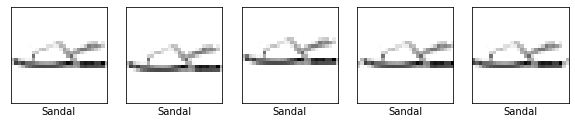

In [34]:
plt.figure(figsize=(10,10))
k=0
for i in range(1455,300000,60000):
    k=k+1
    plt.subplot(1,5,k)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_aug[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_lab[i]])
plt.show()

In [35]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [36]:
history_aug = model.fit(train_aug, train_lab, epochs=10,  
                         validation_data=(x_test_scaled, y_test),verbose=1)

Train on 300000 samples, validate on 10000 samples
Epoch 1/10
300000/300000 [==============================] - 16s 54us/sample - loss: 0.4337 - accuracy: 0.8429 - val_loss: 0.3591 - val_accuracy: 0.8742
Epoch 2/10
300000/300000 [==============================] - 16s 54us/sample - loss: 0.3383 - accuracy: 0.8759 - val_loss: 0.3420 - val_accuracy: 0.8761
Epoch 3/10
300000/300000 [==============================] - 16s 53us/sample - loss: 0.3104 - accuracy: 0.8857 - val_loss: 0.3355 - val_accuracy: 0.8806
Epoch 4/10
300000/300000 [==============================] - 16s 52us/sample - loss: 0.2927 - accuracy: 0.8921 - val_loss: 0.3211 - val_accuracy: 0.8872
Epoch 5/10
300000/300000 [==============================] - 16s 52us/sample - loss: 0.2803 - accuracy: 0.8964 - val_loss: 0.3180 - val_accuracy: 0.8882
Epoch 6/10
300000/300000 [==============================] - 16s 52us/sample - loss: 0.2702 - accuracy: 0.8992 - val_loss: 0.3296 - val_accuracy: 0.8897
Epoch 7/10
300000/300000 [===========

In [37]:
test_loss_aug, test_acc_aug = model.evaluate(x_test_scaled, y_test, verbose=0)
test_acc_diff = test_acc_aug - test_acc_base
test_loss_diff = test_loss_aug - test_loss_base
print('\nTest Loss:', test_loss_aug)
print('\nTest Accuracy:', test_acc_aug)
print('\nTest Loss Difference:', test_loss_diff)
print('\nTest Accuracy Difference:', test_acc_diff)


Test Loss: 0.3237442334771156

Test Accuracy: 0.8933

Test Loss Difference: -0.009114202344417566

Test Accuracy Difference: 0.008700013


Once again we had very insignificant changes. Loss has decreased from base, and accuracy has increased.

## Conclusion
For this notebook we have:
- Applied parrameter norm penalties
- Applied dropout
- Applied early stopping
- Introduced data samples with noise added
- Introduced data samples that are translated or shifted

These are tools all useful to help increase accuracy and decrease loss in training models. However with our current model, hyperparameters and dataset these improvements were not fully apparent, and further testing of parameters needs to be done.